# TinyVLA

In [ ]:
import requests

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM 


device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base", torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)

print("Number of Model Parameters:", sum(p.numel() for p in model.parameters()))

c:\Python38\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Florian Frick\.cache\huggingface\hub\models--microsoft--Florence-2-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- configuration_

{'<OD>': {'bboxes': [[34.23999786376953, 160.0800018310547, 597.4400024414062, 371.7599792480469], [272.32000732421875, 241.67999267578125, 303.67999267578125, 247.4399871826172], [454.0799865722656, 276.7200012207031, 553.9199829101562, 370.79998779296875], [96.31999969482422, 280.55999755859375, 198.0800018310547, 371.2799987792969]], 'labels': ['car', 'door handle', 'wheel', 'wheel']}}


In [26]:
prompt = "<OD>"

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=4096,
    num_beams=3,
    do_sample=False
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))

print(parsed_answer)

{'<OD>': {'bboxes': [[34.23999786376953, 160.0800018310547, 597.4400024414062, 371.7599792480469], [272.32000732421875, 241.67999267578125, 303.67999267578125, 247.4399871826172], [454.0799865722656, 276.7200012207031, 553.9199829101562, 370.79998779296875], [96.31999969482422, 280.55999755859375, 198.0800018310547, 371.2799987792969]], 'labels': ['car', 'door handle', 'wheel', 'wheel']}}


<Figure size 1000x1000 with 0 Axes>

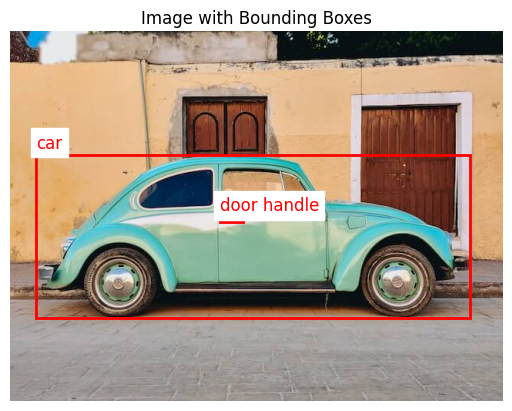

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the image
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

# Parsed bounding box data from your results
parsed_answer = {
    "<OD>": {
        "bboxes": [
            [33.599998474121094, 160.55999755859375, 596.7999877929688, 371.7599792480469],
            [271.67999267578125, 242.1599884033203, 302.3999938964844, 246.95999145507812]
        ],
        "labels": ["car", "door handle"]
    }
}

bboxes = parsed_answer["<OD>"]["bboxes"]
labels = parsed_answer["<OD>"]["labels"]


# Plot image with bounding boxes
plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(1)
ax.imshow(image)

# Add bounding boxes
for bbox, label in zip(bboxes, labels):
    # Extract coordinates
    x_min, y_min, x_max, y_max = bbox
    width = x_max - x_min
    height = y_max - y_min

    # Create rectangle patch
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor="red", facecolor="none")
    ax.add_patch(rect)
    # Add label text
    plt.text(x_min, y_min - 10, label, color="red", fontsize=12, backgroundcolor="white")

plt.axis("off")
plt.title("Image with Bounding Boxes")
plt.show()